In [295]:
%matplotlib inline

In [296]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')


In [297]:
import glob
import os

def get_latest_file_glob(pat):    
    list_of_files = glob.glob(pat) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [298]:
latest_niv = get_latest_file_glob('data/corona_tested_individuals_ver_*.csv.gz')
niv = pd.read_csv(latest_niv, 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-07-19,1,0,0,0,0,שלילי,No,נקבה,Abroad
1,2020-07-19,0,0,0,0,0,שלילי,No,נקבה,Abroad
2,2020-07-19,0,1,0,0,0,שלילי,No,זכר,Abroad
3,2020-07-19,1,0,0,0,0,שלילי,No,זכר,Other
4,2020-07-19,0,0,0,0,0,שלילי,No,נקבה,Other


In [299]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [300]:
latest_bdi = get_latest_file_glob('data/corona_lab_tests_ver_*.csv.gz')
bdi = pd.read_csv(latest_bdi, encoding='utf-8', parse_dates=[0,1])

In [301]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [302]:
bdi.head()

,test_date,result_date,corona_result,lab_id,is_first_Test,orig_test_date
0,2020-03-18,2020-03-18,חיובי,32,No,NaT
1,2020-03-18,2020-03-18,חיובי,1,No,NaT
2,2020-03-20,2020-03-20,שלילי,4,Yes,NaT
3,2020-03-20,2020-03-20,שלילי,4,Yes,NaT
4,2020-03-20,2020-03-20,שלילי,4,Yes,NaT


In [303]:
bdi.shape

(1472636, 6)

In [304]:
bdi.corona_result.value_counts()

שלילי               1363967
חיובי                 80833
לא בוצע/פסול 999      17151
חיובי גבולי            9692
בעבודה                  595
לא ודאי                 398
Name: corona_result, dtype: int64

In [305]:
niv.corona_result.value_counts()

שלילי    980393
חיובי     44469
אחר       12986
Name: corona_result, dtype: int64

In [306]:
niv.test_indication.value_counts()

Other                     982324
Abroad                     27993
Contact with confirmed     27531
Name: test_indication, dtype: int64

In [307]:
niv.age_60_and_above.value_counts()

No     483908
Yes     70994
Name: age_60_and_above, dtype: int64

In [308]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [309]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [310]:
bdi['corona_result'] = bdi.corona_result.map(result_map)

In [311]:
rec = pd.read_csv(get_latest_file_glob('data/corona_recovered_ver_*.csv.gz'), encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,19,9,40-49,זכר,Abroad
1,22,9,30-39,זכר,Contact with confirmed
2,26,9,30-39,זכר,Contact with confirmed
3,28,9,30-39,נקבה,Abroad
4,23,9,20-29,נקבה,Contact with confirmed


In [312]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

,total_tests_count,size,min,max,mean,median,test_sum
0,2,5,6,17,12.600000,12,10
1,3,9632,2,112,16.571013,17,28896
2,4,4474,2,105,21.315825,21,17896
3,5,2859,2,106,24.626793,25,14295
4,6,1692,6,96,27.681442,27,10152
5,7,1024,8,63,30.338867,30,7168
6,8,588,3,103,33.472789,33,4704
7,9,352,3,78,35.590909,35,3168
8,10,567,5,106,41.126984,41,5670


In [313]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]


,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
11319,112,3,30-39,זכר,Contact with confirmed
5925,106,5,30-39,זכר,Contact with confirmed
20722,106,10+,0-19,נקבה,Contact with confirmed
8921,105,4,30-39,נקבה,Other
436,103,8,50-59,נקבה,Contact with confirmed
20860,100,10+,60+,זכר,Contact with confirmed
20838,99,10+,60+,זכר,Other
8031,98,4,40-49,נקבה,Other
8411,98,4,20-29,זכר,Contact with confirmed
20756,97,10+,60+,נקבה,Other


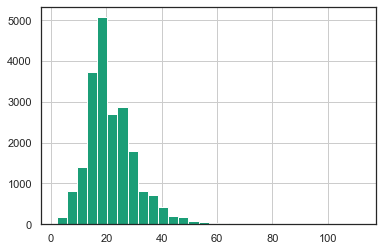

In [314]:
rec.days_between_pos_and_neg.hist(bins=30)

In [315]:
iso = pd.read_csv(get_latest_file_glob('data/corona_isolation_per_day_ver_*.csv.gz'),
                  encoding='utf-8-sig', low_memory=False)
iso.head()

,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad
0,2020-07-18,41616,8314,3180,295
1,2020-07-17,43420,8721,3920,479
2,2020-07-16,48471,9149,5846,809
3,2020-07-15,50757,9110,5621,679
4,2020-07-14,54522,8966,6234,785


In [316]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [317]:
niv.age_60_and_above.value_counts()

No     483908
Yes     70994
Name: age_60_and_above, dtype: int64

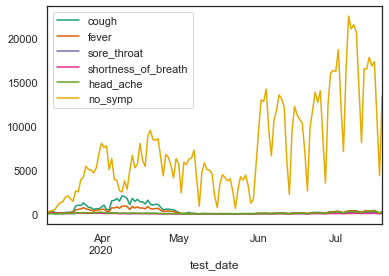

In [318]:
niv.groupby('test_date')[symptom_cols].sum().plot()

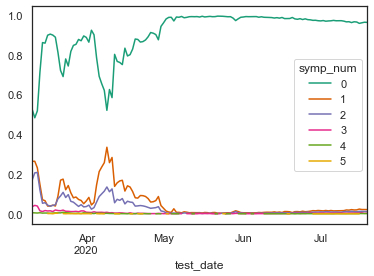

In [319]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

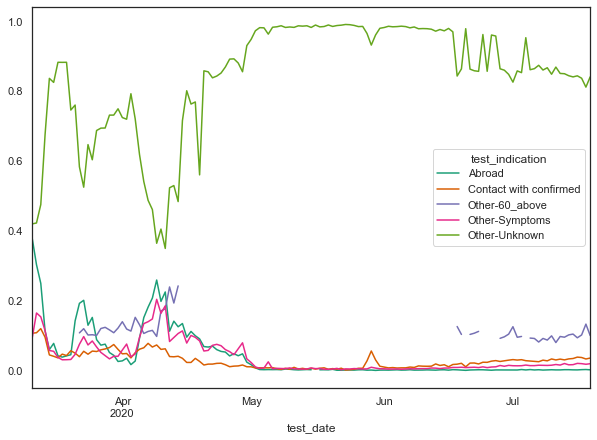

In [320]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

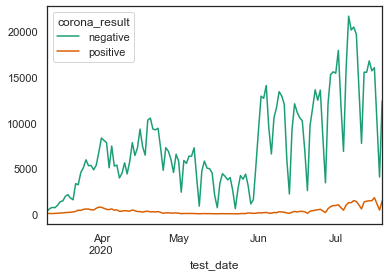

In [321]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [322]:
bdi.dtypes

test_date         datetime64[ns]
result_date       datetime64[ns]
corona_result             object
lab_id                     int64
is_first_Test             object
orig_test_date    datetime64[ns]
dtype: object

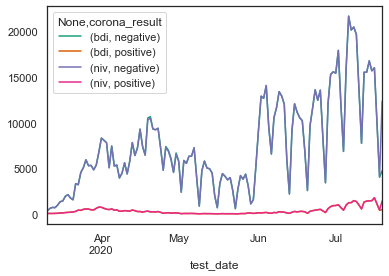

In [323]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

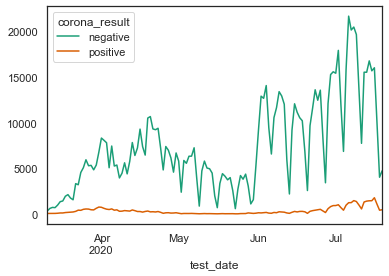

In [324]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [325]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='No')].groupby(['test_date', 'corona_result']).size().unstack()

corona_result,negative,positive
test_date,,
2020-03-11,3,3
2020-03-12,20,6
2020-03-13,17,2
2020-03-14,25,3
2020-03-15,70,45
...,...,...
2020-07-15,12759,1294
2020-07-16,12154,1231
2020-07-17,8059,906


In [326]:
pone = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'corona_result']).size().unstack()
pone[pone.positive<20]

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-05-02,36.0,NaN,2375.0,18.0,NaN
2020-05-08,27.0,NaN,3947.0,18.0,NaN
2020-05-09,31.0,NaN,849.0,9.0,NaN
2020-05-12,46.0,NaN,5021.0,19.0,NaN
2020-05-14,60.0,1.0,4469.0,16.0,NaN
2020-05-15,28.0,NaN,1979.0,7.0,NaN
2020-05-16,24.0,NaN,675.0,4.0,NaN
2020-05-17,59.0,NaN,3341.0,15.0,NaN
2020-05-19,32.0,NaN,4124.0,12.0,NaN


In [327]:
pone.tail(5)

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-07-15,318.0,NaN,15689.0,1440.0,NaN
2020-07-16,271.0,1.0,16022.0,1767.0,NaN
2020-07-17,160.0,NaN,9953.0,1066.0,1.0
2020-07-18,52.0,NaN,4015.0,400.0,NaN
2020-07-19,51.0,NaN,4723.0,447.0,NaN


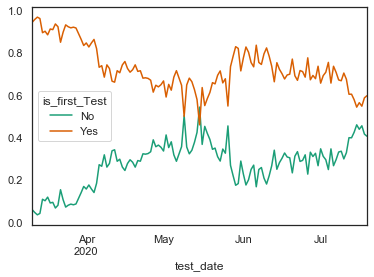

In [328]:
ti = bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

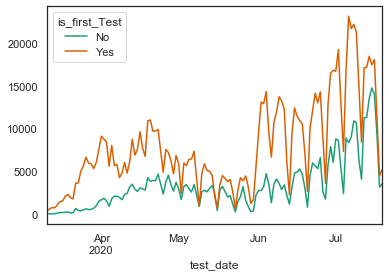

In [329]:
ti.plot()

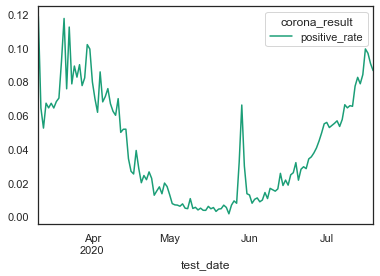

In [330]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']]
 .plot())

In [331]:
import altair as alt
ti.tail()

is_first_Test,No,Yes
test_date,,
2020-07-15,14750,17447
2020-07-16,14021,18061
2020-07-17,9281,11180
2020-07-18,3157,4467
2020-07-19,3539,5221


In [332]:
ti.Yes.sum() + ti.No.sum()

1472636

In [365]:
alt.Chart(ti.reset_index().assign(total=lambda x: x.Yes+x.No)).mark_line().encode(
    x='test_date',
    y='Yes',
    tooltip=['test_date', 'Yes']
).interactive()

alt.Chart(...)

In [334]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [335]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [336]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'חולים בינוני': 'medium',
            'מונשמים': 'resp'}

In [337]:
hos = (pd.read_csv(get_latest_file_glob('data/corona_hospitalization_ver_*.csv.gz'), encoding='utf-8-sig', low_memory=False, na_values=['None'])
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.str.replace('<15', '15').astype(int))
      .assign(medium = lambda x: x.medium.fillna('<15').str.replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.str.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.head()

,date,מאושפזים,אחוז נשים מאושפזות,גיל ממוצע מאושפזים,סטיית תקן גיל מאושפזים,resp,אחוז נשים מונשמות,גיל ממוצע מונשמים,סטיית תקן גיל מונשמים,חולים קל,...,גיל ממוצע חולים קל,סטיית תקן גיל חולים קל,medium,אחוז נשים חולות בינוני,גיל ממוצע חולים בינוני,סטיית תקן גיל חולים בינוני,critical,אחוז נשים חולות קשה,גיל ממוצע חולים קשה,סטיית תקן גיל חולים קשה
0,2020-03-11,75,36.0,48.0,17.4,15,20.0,63.0,15.3,68,...,47.0,16.8,15,NaN,NaN,NaN,15,33.3,67.0,16.2
1,2020-03-12,97,39.2,50.0,18.0,15,20.0,63.0,15.3,90,...,49.0,17.7,15,NaN,NaN,NaN,15,33.3,67.0,16.2
2,2020-03-13,115,39.1,49.0,17.9,15,20.0,63.0,15.3,105,...,47.0,17.4,15,50.0,64.0,17.3,15,33.3,67.0,16.2
3,2020-03-14,153,41.2,47.0,18.3,15,0.0,70.0,7.4,144,...,46.0,17.5,15,50.0,64.0,17.3,15,20.0,76.0,10.3
4,2020-03-15,192,44.3,46.0,18.6,15,20.0,74.0,7.6,178,...,45.0,17.6,15,50.0,58.0,14.9,15,37.5,79.0,9.1


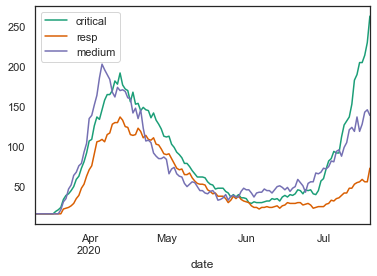

In [338]:
(hos[['date', 'critical', 'resp', 'medium']].set_index('date').plot())

In [339]:
hos_and_rate = hos[['date', 'critical', 'resp', 'medium']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


,test_date,critical,resp,medium,negative,positive,positive_rate
0,2020-03-11,15,15,15,319,43,0.118785
1,2020-03-12,15,15,15,597,41,0.064263
2,2020-03-13,15,15,15,706,39,0.052349
3,2020-03-14,15,15,15,681,49,0.067123
4,2020-03-15,15,15,15,960,66,0.064327


In [340]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [341]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positives (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

No handles with labels found to put in legend.


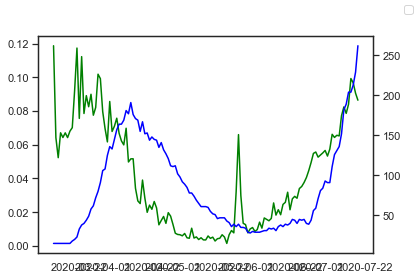

In [342]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()


In [343]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical+med')
               .assign(crit_med = lambda x: (x.critical+x.medium).ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_med',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [344]:
hos_and_rate['pos_pct_change'] = hos_and_rate.positive_rate.pct_change()
hos_and_rate['crit_pct_change'] = hos_and_rate.critical.pct_change()


In [345]:
c1 = alt.Chart(hos_and_rate
               .assign(pos_pct_change = lambda x: x.pos_pct_change.ewm(span=7).mean())
              ).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='pos_pct_change',
    tooltip=['test_date', 'positive_rate'],
)
c2 = alt.Chart(hos_and_rate
               .assign(crit_pct_change = lambda x: x.crit_pct_change.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_pct_change',
    tooltip=['test_date', 'critical'],
)


alt.layer(c1, c2).properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

## Positive rate by Lab

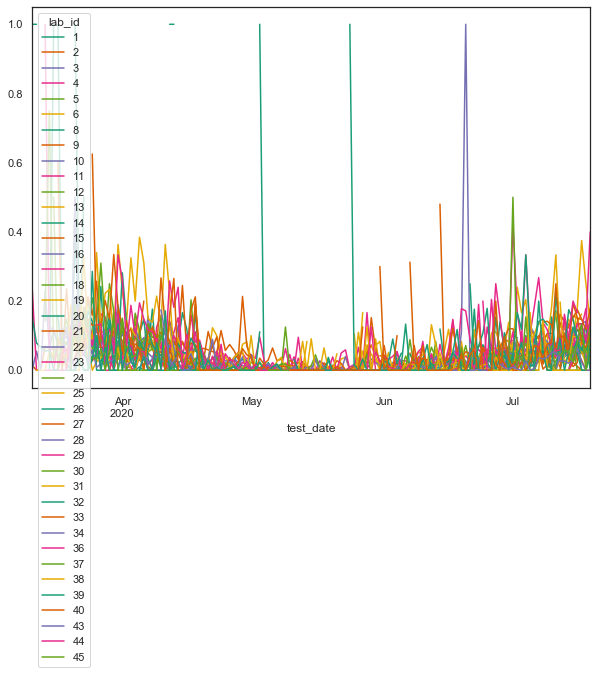

In [346]:
polab = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'lab_id', 'corona_result']).size().unstack().fillna(0)
polab['total_tests'] = polab.sum(axis=1)
polab['positive_rate'] = polab.positive/(polab.positive+polab.negative)
polab.positive_rate.unstack().plot(figsize=(10,7))

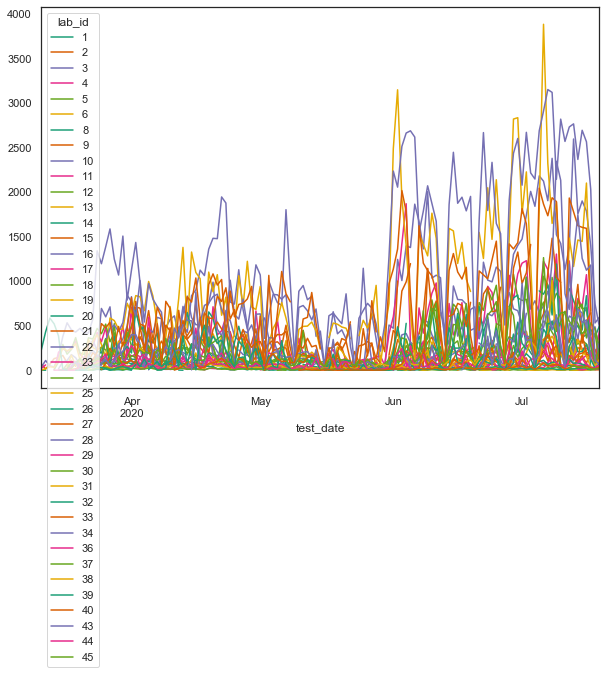

In [347]:
polab.total_tests.unstack().plot(figsize=(10,7))

In [348]:
(polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1)))

corona_result,positive,negative,total_tests,positive_rate
lab_id,,,,
16,6512.0,134076.0,141030.0,2.4
3,4625.0,114634.0,120326.0,2.0
13,4799.0,102315.0,110042.0,2.3
21,5843.0,74916.0,80984.0,3.9
4,1736.0,48858.0,51153.0,1.8
10,1871.0,47249.0,50247.0,2.0
15,3026.0,44472.0,47971.0,3.4
12,1429.0,35781.0,37942.0,2.0
27,501.0,36239.0,36750.0,0.7


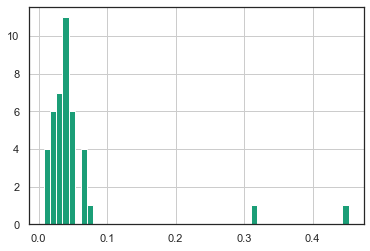

In [349]:
polab.reset_index().groupby('lab_id').positive_rate.mean().hist(bins=50)

In [350]:
top_5_labs = bdi.lab_id.value_counts().index[:5]
top_5_labs

Int64Index([3, 16, 13, 21, 43], dtype='int64')

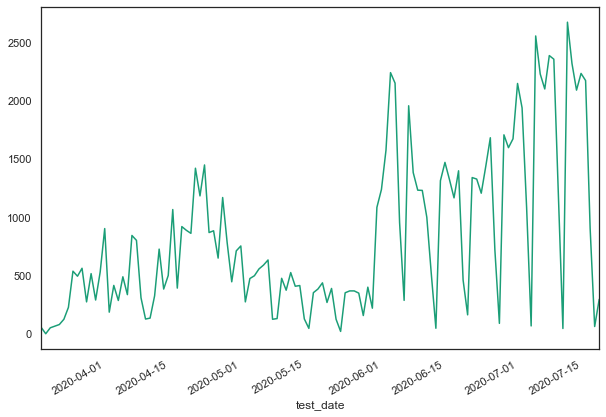

In [351]:
bdi[(bdi.lab_id==21)].groupby('test_date').size().plot(figsize=(10,7))

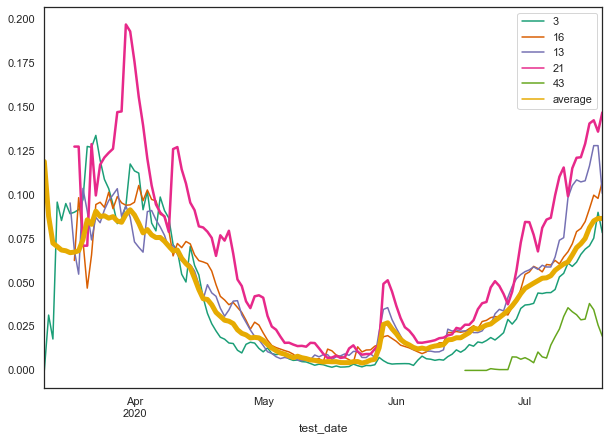

In [352]:
sns.set_palette(['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02'])
ax = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1).ewm(span=7).mean().plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=[1.5,1.5,1.5,2.5,1.5,5][i])


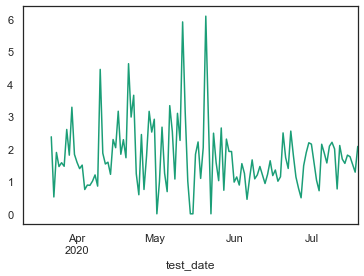

In [353]:
top_labs_pr = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1)
top_labs_pr['ratio_21'] = top_labs_pr.loc[:, 21]/top_labs_pr.average
top_labs_pr.ratio_21.plot()

In [354]:
bdi[bdi.lab_id==21].shape[0]/bdi.shape[0]

0.0696234507373173

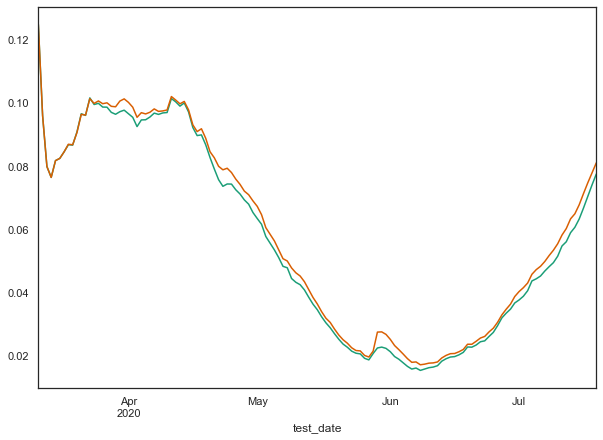

In [355]:
ax = (bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo.ewm(7).mean().plot(figsize=(10,7))
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr.ewm(7).mean().plot(ax=ax, figsize=(10,7))

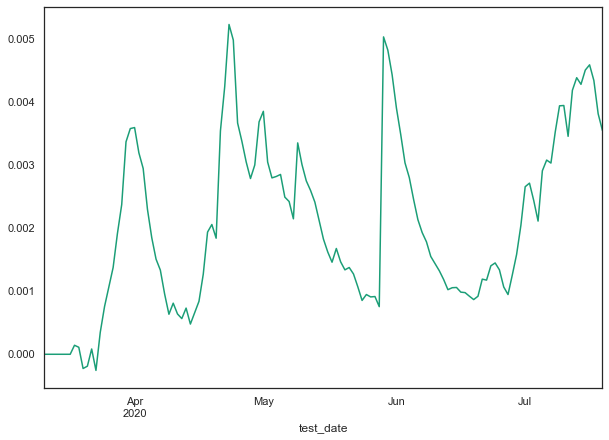

In [356]:
pd.concat([(bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo,
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr], axis=1).assign(dif = lambda x: x.pr-x.pr_wo).dif.ewm(7).mean().plot(figsize=(10,7))

## Decseased 

In [392]:
last_dec = pd.read_csv(get_latest_file_glob('data/corona_deceased_ver*.csv.gz'), 
                       encoding='utf-8-sig', low_memory=False)
last_dec['qc'] = pd.qcut(last_dec.Length_of_hospitalization, 11)
last_dec.qc.value_counts().sort_index()/len(last_dec)

(-0.001, 0.455]    0.090686
(0.455, 3.0]       0.132353
(3.0, 5.0]         0.093137
(5.0, 6.0]         0.063725
(6.0, 8.0]         0.095588
(8.0, 9.0]         0.066176
(9.0, 12.0]        0.117647
(12.0, 15.0]       0.068627
(15.0, 22.0]       0.093137
(22.0, 33.545]     0.073529
(33.545, 107.0]    0.090686
Name: qc, dtype: float64

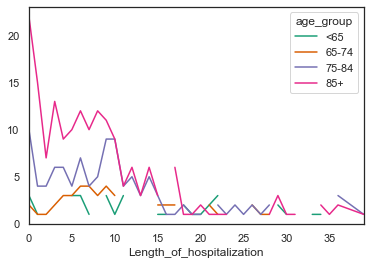

In [404]:
x = last_dec[last_dec['Length_of_hospitalization']<40].groupby(['Length_of_hospitalization', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.plot()

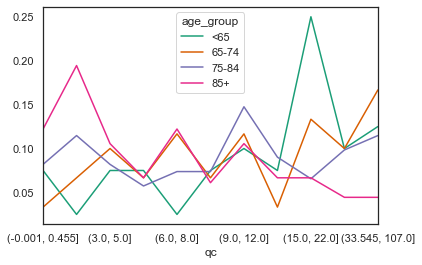

In [405]:
x = last_dec.groupby(['qc', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=0), axis=1).plot()

In [387]:
(last_dec.Length_of_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

0.0    0.090686
1.0    0.051471
2.0    0.029412
3.0    0.051471
4.0    0.044118
5.0    0.049020
6.0    0.063725
7.0    0.046569
8.0    0.049020
9.0    0.066176
Name: Length_of_hospitalization, dtype: float64

In [390]:
(last_dec.Time_between_positive_and_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

-36.0    0.002451
-21.0    0.002451
-15.0    0.002451
-9.0     0.002451
-8.0     0.002451
-6.0     0.002451
-4.0     0.007353
-3.0     0.004902
-1.0     0.120098
 0.0     0.340686
Name: Time_between_positive_and_hospitalization, dtype: float64

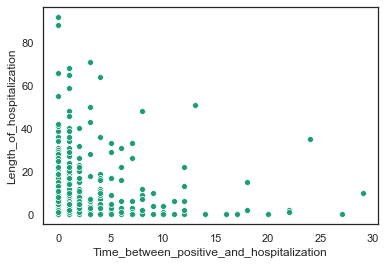

In [389]:
sns.scatterplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='Time_between_positive_and_hospitalization', y='Length_of_hospitalization')

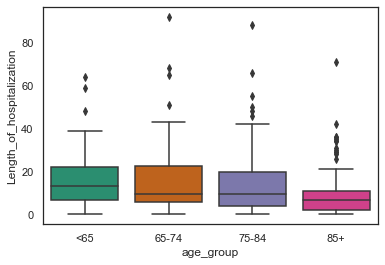

In [406]:
sns.boxplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='age_group', y='Length_of_hospitalization', order=['<65', '65-74', '75-84', '85+'])

In [357]:
decs = []
for file in sorted(glob.glob('data/corona_deceased_ver*.csv.gz'), key=os.path.getctime) :
    dec = pd.read_csv(file, 
                  encoding='utf-8-sig', low_memory=False)
    dec['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    dec.time = dec.time
    dec['file'] = file
    decs.append(dec)

decs = pd.concat(decs).sort_values('time')
decs.head()

,gender,age_group,Ventilated,Time_between_positive_and_hospitalization,Length_of_hospitalization,Time_between_positive_and_death,time,file
0,זכר,<65,1.0,2.0,20.0,22,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
203,נקבה,75-84,1.0,0.0,12.0,12,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
202,נקבה,85+,0.0,10.0,1.0,11,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
201,נקבה,85+,0.0,2.0,17.0,19,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
200,זכר,85+,1.0,0.0,9.0,9,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz


In [358]:
decs.shape, (decs.drop_duplicates(subset=['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death']).shape)

((3675, 8), (374, 8))

In [359]:
decs.columns

Index(['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death', 'time',
       'file'],
      dtype='object')

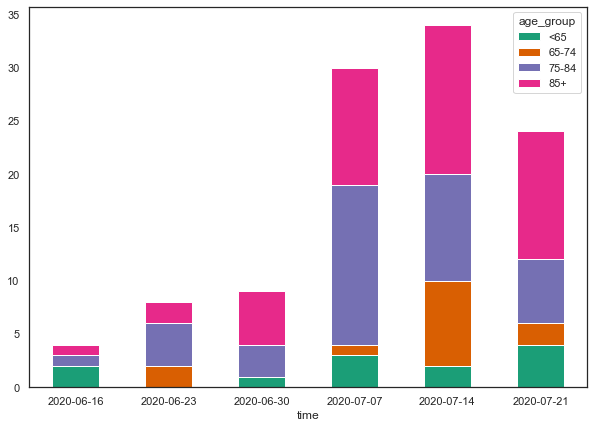

In [360]:
dec_dif = decs.groupby(['time', 'age_group']).size().unstack().diff()

dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

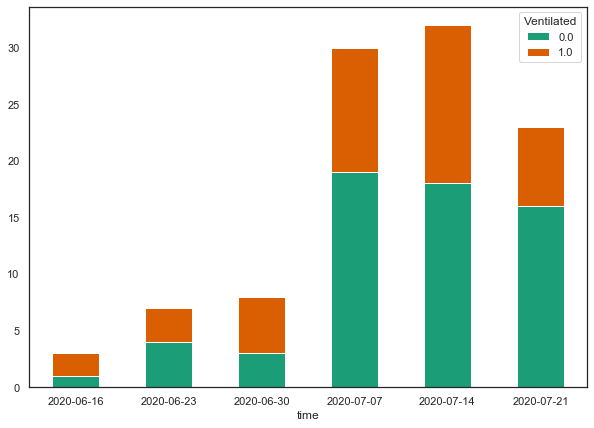

In [361]:
dec_dif = decs.groupby(['time', 'Ventilated']).size().unstack().diff()

dec_dif.resample('7d', kind='period').sum().plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

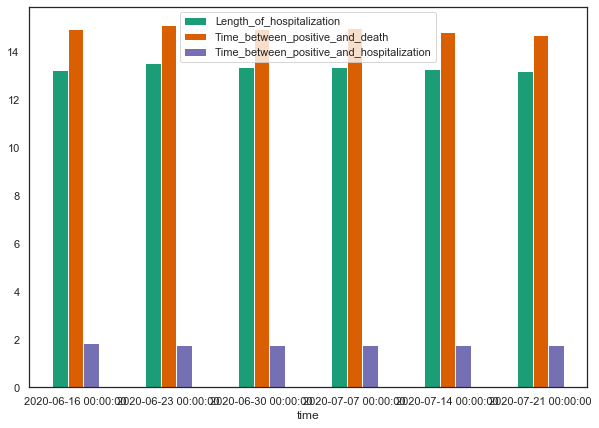

In [362]:
decs.resample('7d', on='time')[['Length_of_hospitalization', 'Time_between_positive_and_death', 'Time_between_positive_and_hospitalization']].mean().plot(kind='bar', figsize=(10,7), rot=0)


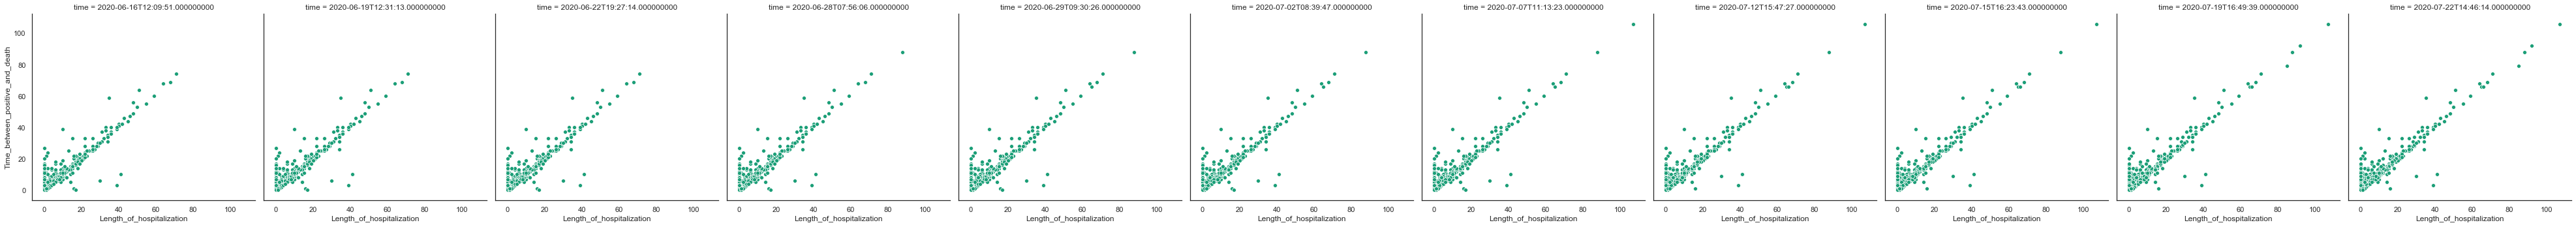

In [363]:
sns.relplot(data=decs, col='time', x='Length_of_hospitalization', y='Time_between_positive_and_death', kind='scatter')